# Import Necessary Libraries

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt


# Load and Prepare Data

In [10]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.

# Reshape the data to include channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Function to add noise
def add_noise(images, noise_factor=0.5):
    noise = np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise_factor * noise
    return np.clip(noisy_images, 0., 1.)

# Add noise to the images
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)





# Build the Autoencoder Model

In [33]:
# Build the Encoder


# Build the Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

encoder = Model(input_img, encoded, name='encoder')

# Print encoder summary
encoder.summary()

# Plot encoder model
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='encoder_model.png', show_shapes=True, show_layer_names=True)

from tensorflow.keras.layers import UpSampling2D

# Build the Decoder
decoder_input = Input(shape=(7, 7, 16))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, decoded, name='decoder')

# Print decoder summary
decoder.summary()

# Plot decoder model
plot_model(decoder, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

# Build the Autoencoder
autoencoder_input = Input(shape=(28, 28, 1))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded, name='autoencoder')

# Print autoencoder summary
autoencoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 7, 7, 16)          4624

# Train the Autoencoder

In [35]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))




Epoch 1/50
469/469 [==============================] - 5s 7ms/step - loss: 0.3366 - val_loss: 0.3128
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.3061 - val_loss: 0.3058
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3018 - val_loss: 0.3021
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2992 - val_loss: 0.3005
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2975 - val_loss: 0.2985
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2960 - val_loss: 0.2976
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2949 - val_loss: 0.2963
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2940 - val_loss: 0.2961
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2931 - val_loss: 0.2947
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.2925 - val_loss: 0.2940

# Visualise the training and validation loss

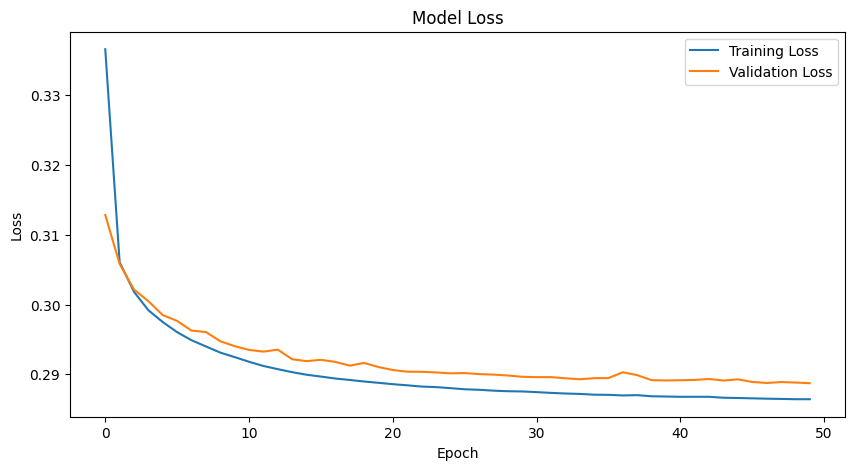

In [36]:
# Plotting the training and validation losses
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Evaluate the Results

313/313 [==============================] - 1s 3ms/step


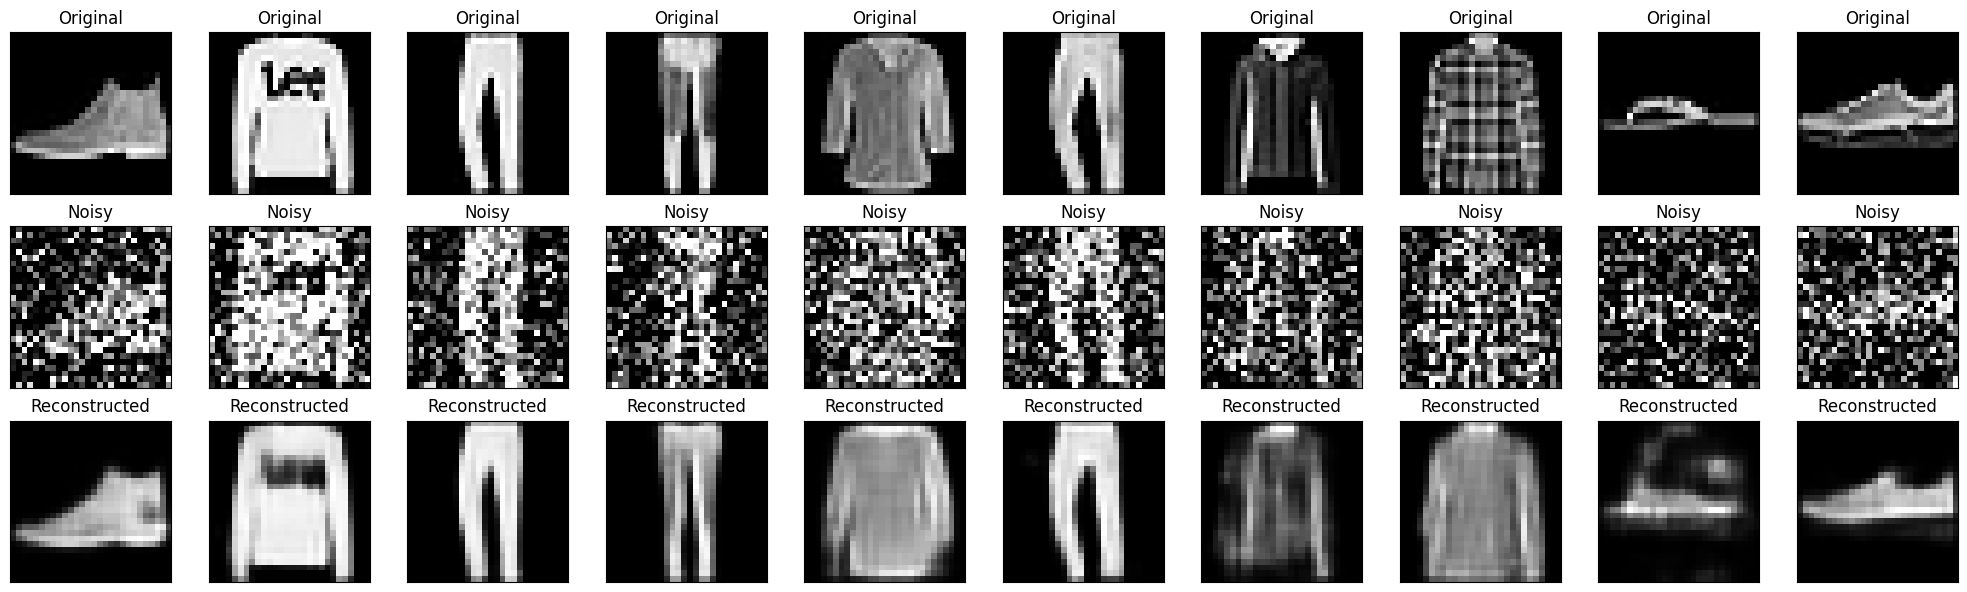

In [31]:
# Visualise the results
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()